# Course Project: Minimizing SUMMA Model Misfits at the Cues Site
CVU - Intro to Snow Hydrology: Focus on Modeling

Bareera Mirza & Rainey Aberle

29 October 2021

### Project Objective and Description:

Tuning model at Umpqua or Cues to better fit the observations. Outcomes can help in ‘prepping’ for a climate sensitivity test so that model better represents observations. Results can explain that each decision is what we would expect for the site.

### SUMMA parameters / decisions tested to minimize misfits with site observations:
1. Albedo scheme via `alb_method` decision:<br>
a. `varDecay` <br>
b. `conDecay`<br>
2. Layering scheme<br>
a. CLM<br>
b. JRDN1991 <br>
c. Thin 2-layer<br>
d. Thick 2-layer<br>
3. Snow Inception via `snowIncept` decision:<br> 
a. `stickySnow` <br>
b. `lightSnow`

----
### Introduction

[insert study site image and description]

--------

### Run the Tests
#### Set path to the cues folder

In [1]:
homepath = '/home/jovyan/data/cues/'

#### Import Packages

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt # if you want to do some plotting using matplotlib (optional)
import numpy as np # provide some mathematical functions
import xarray as xr # read, write, manipulate and analyze NetCDF files
from pathlib import Path
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
import warnings
warnings.filterwarnings('ignore')
import pysumma as ps
import csv
import pandas as pd
from datetime import date
from sklearn.metrics import mean_squared_error

#### Load observed daily snow depth at the site

In [3]:
obs_file = str(homepath+'data/CUESDailySnowDepth20010320to20150428.csv')
obs = pd.read_csv(obs_file, sep=',')
obs

,date,snowdepth_cm
0,2001-03-20,367.70
1,2001-03-21,284.45
2,2001-03-22,278.20
3,2001-03-23,277.55
4,2001-03-24,275.10
...,...,...
5148,2015-04-24,44.25
5149,2015-04-25,56.65
5150,2015-04-26,52.40
5151,2015-04-27,45.40


#### Setup the SUMMA executable and file manager

In [4]:
executable = 'summa.exe'
filemanager = str(homepath+'summa_setup/settings/file_manager_cues.txt')
filemanager

'/home/jovyan/data/cues/summa_setup/settings/file_manager_cues.txt'

----------------

### 1. Albedo formulation via `alb_method` decision
#### a. `varDecay`

In [5]:
# Initialize simulation
s_var = ps.Simulation(executable, filemanager)

# Set the simulation start and end times
#    - snow depth observations available: 2001-03-20 to 2015-04-28
#    - forcing files available: 2011 - 2017
s_var.manager['simStartTime'] = '2011-10-01 00:00'
s_var.manager['simEndTime'] = '2015-04-28 00:00'

# Change the alb_method decision to varDecay
s_var.decisions['alb_method'] = 'varDecay'
print(s_var.decisions['alb_method'])

# Make sure snow depth is included in the output variables
output_settings = {'period': 1, 'instant': 1, 'sum': 0, 
              'mean': 0, 'variance': 0, 'min': 0, 'max': 0}
layer_vars = ['mLayerDepth', 'scalarSnowDepth']

# Create the new output variables
for var in layer_vars:
    s_var.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_var.output_control.options])
for var in all_vars:
    s_var.output_control[var] = output_settings

# Run simulation
s_var.run('local', run_suffix='_varDecay')
s_var.status

alb_method    varDecay             ! choice of albedo representation


'Success'

#### b. `conDecay`

In [6]:
# Initialize simulation
s_con = ps.Simulation(executable, filemanager)

# Set the simulation start and end times
#    - snow depth observations available: 2001-03-20 to 2015-04-28
#    - forcing files available: 2011 - 2017
s_con.manager['simStartTime'] = '2011-10-01 00:00'
s_con.manager['simEndTime'] = '2015-04-28 00:00'

# Change the alb_method decision to conDecay
s_con.decisions['alb_method'] = 'conDecay'
print(s_con.decisions['alb_method'])

# Make sure snow depth is included in the output variables
output_settings = {'period': 1, 'instant': 1, 'sum': 0, 
              'mean': 0, 'variance': 0, 'min': 0, 'max': 0}
layer_vars = ['mLayerDepth', 'scalarSnowDepth']

# Create the new output variables
for var in layer_vars:
    s_con.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_con.output_control.options])
for var in all_vars:
    s_con.output_control[var] = output_settings

# Run simulation
s_con.run('local', run_suffix='_conDecay')
s_con.status

alb_method    conDecay             ! choice of albedo representation


'Success'

#### Plot results


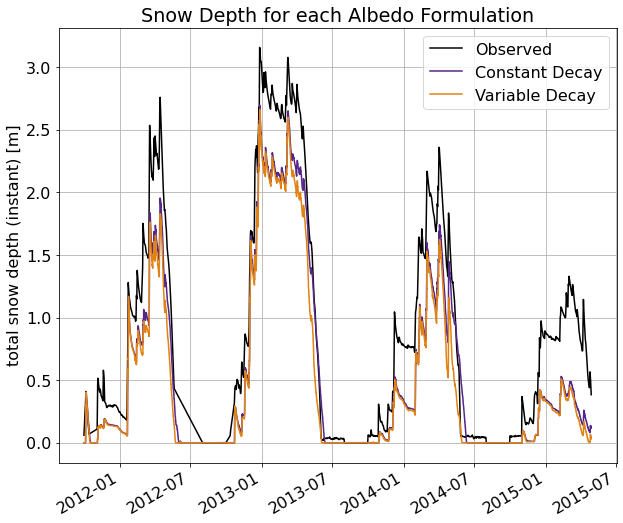

In [7]:
# Convert observed dates to datetime format
obs['date'] = pd.to_datetime(obs['date'])
# Interpolate the snow depth observations onto the simulation time period
obs_interp = np.interp(s_var.output['time'],obs['date'],obs['snowdepth_cm'])

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
plt.plot(s_var.output['time'],obs_interp/100, label='Observed', color='black')
s_con.output['scalarSnowDepth'].plot(label='Constant Decay', color='#542788')
s_var.output['scalarSnowDepth'].plot(label='Variable Decay', color='#e08214')
plt.title('Snow Depth for each Albedo Formulation')
plt.grid()
plt.xlabel('')
plt.legend()

#### Calculate Root Mean Squared Error (RMSE) with observations

In [8]:
# Calculate RMSE
rmse_var = mean_squared_error(obs_interp/100, s_var.output['scalarSnowDepth'], squared=True)
rmse_con = mean_squared_error(obs_interp/100, s_con.output['scalarSnowDepth'], squared=True)

# Determine simulation with lowest RMSE
rmse_min = np.min([rmse_var, rmse_con])

# Print the best fit layering scheme
if rmse_min==rmse_var:
    print('Best fit = Variable Decay Albedo')
elif rmse_min==rmse_con:
    print('Best fit = Constant Decay Albedo')
    
print('RMSE = ',np.round(rmse_min,4),'m')
print('Use this albedo formulation in the following steps.')

Best fit = Constant Decay Albedo
RMSE =  0.1392 m
Use this albedo formulation in the following steps.


### 2. Layering scheme
#### a. CLM Layering

In [9]:
# Initialize simulation
s_con_clm = ps.Simulation(executable, filemanager)

# Set the simulation start and end times
#    - snow depth observations available: 2001-03-20 to 2015-04-28
#    - forcing files available: 2011 - 2017
s_con_clm.manager['simStartTime'] = '2011-10-01 00:00'
s_con_clm.manager['simEndTime'] = '2015-04-28 00:00'
    
# Change the alb_method decision to conDecay
s_con_clm.decisions['alb_method'] = 'conDecay'

# Create the new output variables
for var in layer_vars:
    s_con_clm.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_con_clm.output_control.options])
for var in all_vars:
    s_con_clm.output_control[var] = output_settings

# Run simulation
s_con_clm.run('local', run_suffix='_conDecay_CLM')
s_con_clm.status

'Success'

#### b. JRDN1991 Layering

In [10]:
# Initialize simulation
s_con_jrdn = ps.Simulation(executable, filemanager)

# Set the simulation start and end times
s_con_jrdn.manager['simStartTime'] = '2011-10-01 00:00'
s_con_jrdn.manager['simEndTime'] = '2015-04-28 00:00'

# Change the alb_method decision to conDecay
s_con_jrdn.decisions['alb_method'] = 'conDecay'

# Change layers decision
s_con_jrdn.decisions['snowLayers'] = 'jrdn1991'
    
# Create the new output variables
for var in layer_vars:
    s_con_jrdn.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_con_jrdn.output_control.options])
for var in all_vars:
    s_con_jrdn.output_control[var] = output_settings
    
# Run simulation
s_con_jrdn.run('local', run_suffix='_conDecay_JRDN')
s_con_jrdn.status

'Success'

#### c. Thin 2-Layer

In [11]:
# Initialize simulation
s_con_thin = ps.Simulation(executable, filemanager)

# Set the simulation start and end times
s_con_thin.manager['simStartTime'] = '2011-10-01 00:00'
s_con_thin.manager['simEndTime'] = '2015-04-28 00:00'

# Change the alb_method decision to conDecay
s_con_thin.decisions['alb_method'] = 'conDecay'

# Change layers decision
s_con_thin.decisions['snowLayers'] = 'CLM_2010'

# Modify layers
s_con_thin.global_hru_params['zminLayer3'] = 100.0000
s_con_thin.global_hru_params['zminLayer4'] = 100.0000
s_con_thin.global_hru_params['zminLayer5'] = 100.0000
s_con_thin.global_hru_params['zmaxLayer2_lower'] = 1000.0000
s_con_thin.global_hru_params['zmaxLayer3_lower'] = 1000.0000
s_con_thin.global_hru_params['zmaxLayer4_lower'] = 1000.0000
s_con_thin.global_hru_params['zmaxLayer2_upper'] = 1000.0000
s_con_thin.global_hru_params['zmaxLayer3_upper'] = 1000.0000
s_con_thin.global_hru_params['zmaxLayer4_upper'] = 1000.0000

# Create the new output variables
for var in layer_vars:
    s_con_thin.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_con_thin.output_control.options])
for var in all_vars:
    s_con_thin.output_control[var] = output_settings
    
# Run simulation
s_con_thin.run('local', run_suffix='_conDecay_thin2layer')
s_con_thin.status

'Success'

#### d. Thick 2-Layer

In [12]:
# Initialize simulation
s_con_thick = ps.Simulation(executable, filemanager)

# Set the simulation start and end times
s_con_thick.manager['simStartTime'] = '2011-10-01 00:00'
s_con_thick.manager['simEndTime'] = '2015-04-28 00:00'

# Change the alb_method decision to conDecay
s_con_thick.decisions['alb_method'] = 'conDecay'

# Change the layering decision
s_con_thick.decisions['snowLayers'] = 'CLM_2010'

# Modify layers
s_con_thick.global_hru_params['zminLayer1'] = 0.050
s_con_thick.global_hru_params['zminLayer2'] = 0.020
s_con_thick.global_hru_params['zminLayer3'] = 100.0
s_con_thick.global_hru_params['zminLayer4'] = 100.0
s_con_thick.global_hru_params['zminLayer5'] = 100.0
s_con_thick.global_hru_params['zmaxLayer1_lower'] = 0.2000
s_con_thick.global_hru_params['zmaxLayer2_lower'] = 1000.0
s_con_thick.global_hru_params['zmaxLayer3_lower'] = 1000.0
s_con_thick.global_hru_params['zmaxLayer4_lower'] = 1000.0
s_con_thick.global_hru_params['zmaxLayer1_upper'] = 0.1500
s_con_thick.global_hru_params['zmaxLayer2_upper'] = 1000.0
s_con_thick.global_hru_params['zmaxLayer3_upper'] = 1000.0
s_con_thick.global_hru_params['zmaxLayer4_upper'] = 1000.0

# Create the new output variables
for var in layer_vars:
    s_con_thick.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_con_thick.output_control.options])
for var in all_vars:
    s_con_thick.output_control[var] = output_settings
    
# Run simulation
s_con_thick.run('local', run_suffix='_conDecay_thick2layer')
s_con_thick.status

'Success'

#### Plot results

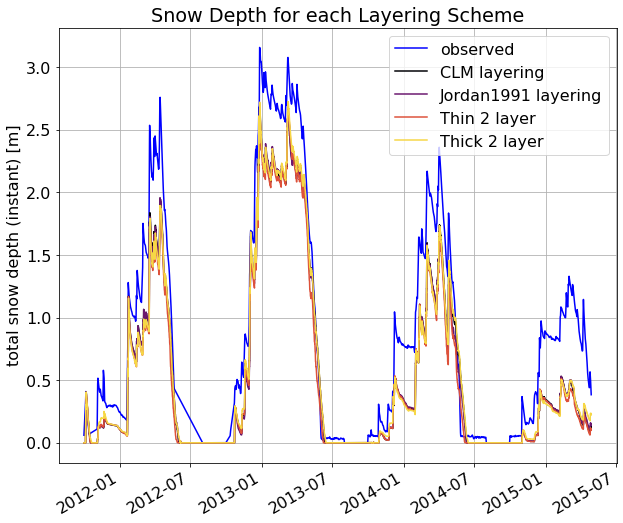

In [14]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
plt.plot(s_con_clm.output['time'],obs_interp/100, label='observed', color='blue')
s_con_clm.output['scalarSnowDepth'].plot(label='CLM layering', color=plt.cm.inferno(0))
s_con_jrdn.output['scalarSnowDepth'].plot(label='Jordan1991 layering', color=plt.cm.inferno(0.3))
s_con_thin.output['scalarSnowDepth'].plot(label='Thin 2 layer', color=plt.cm.inferno(0.6))
s_con_thick.output['scalarSnowDepth'].plot(label='Thick 2 layer', color=plt.cm.inferno(0.9))
plt.title('Snow Depth for each Layering Scheme')
plt.grid()
plt.xlabel('')
plt.legend()
plt.show()

#### Calculate the RMSE of each layering scheme and the observed snow depth

In [15]:
# Calculate the RMSE
rmse_clm = mean_squared_error(obs_interp/100, s_con_clm.output['scalarSnowDepth'], squared=True)
rmse_jrdn = mean_squared_error(obs_interp/100, s_con_jrdn.output['scalarSnowDepth'], squared=True)
rmse_thin = mean_squared_error(obs_interp/100, s_con_thin.output['scalarSnowDepth'], squared=True)
rmse_thick = mean_squared_error(obs_interp/100, s_con_thick.output['scalarSnowDepth'], squared=True)

# Determine the best fit layering scheme
rmse_min = np.min([rmse_clm, rmse_jrdn, rmse_thin, rmse_thick])

# Print the best fit layering scheme
if rmse_min==rmse_clm:
    print('Best fit = CLM layering scheme')
elif rmse_min==rmse_jrdn:
    print('Best fit = JRDN layering scheme')
elif rmse_min==rmse_thin:
    print('Best fit = Thin 2-layer scheme')
elif rmse_min==rmse_thick:
    print('Best fit = Thick 2-layer scheme')
    
print('RMSE = ',np.round(rmse_min,4),' m')
print('Use this layering scheme in the following steps.')

Best fit = CLM layering scheme
RMSE =  0.1392  m
Use this layering scheme in the following steps.


### 2. `snowIncept` decision
#### a. `stickySnow`

In [17]:
# Initialize simulation
s_con_clm_sticky = ps.Simulation(executable, filemanager)

# Initialize simulation
s_con_clm_sticky = ps.Simulation(executable, filemanager)

# Set the simulation start and end times
#    - snow depth observations available: 2001-03-20 to 2015-04-28
#    - forcing files available: 2011 - 2017
s_con_clm_sticky.manager['simStartTime'] = '2011-10-01 00:00'
s_con_clm_sticky.manager['simEndTime'] = '2015-04-28 00:00'
    
# Change the alb_method decision to conDecay
s_con_clm_sticky.decisions['alb_method'] = 'conDecay'

# Change the layering decision
s_con_clm_sticky.decisions['snowLayers'] = 'CLM_2010'

# Change the snowIncept decision to stickySnow
s_con_clm_sticky.decisions['snowIncept'] = 'stickySnow'

# Create the new output variables
for var in layer_vars:
    s_con_clm_sticky.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_con_clm_sticky.output_control.options])
for var in all_vars:
    s_con_clm_sticky.output_control[var] = output_settings

# Run simulation
s_con_clm_sticky.run('local', run_suffix='_conDecay_CLM_sticky')
s_con_clm_sticky.status

'Success'

#### b. `lightSnow`

In [19]:
# Initialize simulation
s_con_clm_light = ps.Simulation(executable, filemanager)

# Set the simulation start and end times
s_con_clm_light.manager['simStartTime'] = '2011-10-01 00:00'
s_con_clm_light.manager['simEndTime'] = '2015-04-28 00:00'

# Change the alb_method decision to conDecay
s_con_clm_light.decisions['alb_method'] = 'conDecay'

# Change the layering decision
s_con_clm_light.decisions['snowLayers'] = 'CLM_2010'

# Change the snowIncept decision to stickySnow
s_con_clm_light.decisions['snowIncept'] = 'lightSnow'

# Create the new output variables
for var in layer_vars:
    s_con_clm_light.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s_con_clm_light.output_control.options])
for var in all_vars:
    s_con_clm_light.output_control[var] = output_settings

# Run simulation
s_con_clm_light.run('local', run_suffix='_conDecay_clm_light')

#### Plot results

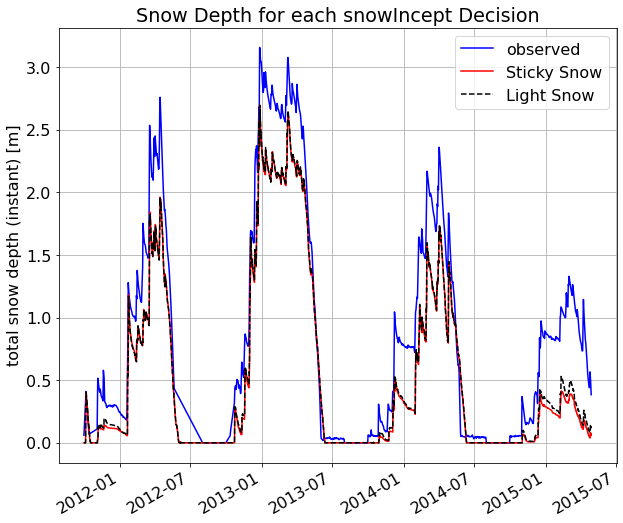

In [20]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
plt.plot(s_con_clm.output['time'],obs_interp/100, label='observed', color='blue')
s_con_clm_sticky.output['scalarSnowDepth'].plot(label='Sticky Snow', 
                                              color='red', linestyle='-')
s_con_clm_light.output['scalarSnowDepth'].plot(label='Light Snow', 
                                             color='black', linestyle='--')
plt.title('Snow Depth for each snowIncept Decision')
plt.grid()
plt.xlabel('')
plt.legend()
plt.show()

#### Calculate the RMSE of each `snowIncept` decision and the observed snow depth

In [21]:
# Calculate the RMSE of snowIncept simulation and the observed snow depth
rmse_sticky = mean_squared_error(obs_interp/100, s_con_clm_sticky.output['scalarSnowDepth'], squared=True)
rmse_light = mean_squared_error(obs_interp/100, s_con_clm_light.output['scalarSnowDepth'], squared=True)

# Determine the best fit snowIncept simulation
rmse_min = np.min([rmse_sticky, rmse_light])

# Print the best fit snowIncept decision
if rmse_min==rmse_sticky:
    print('Best fit = stickySnow')
elif rmse_min==rmse_light:
    print('Best fit = lightSnow')
    
print('RMSE = ',np.round(rmse_min,4),' m')

Best fit = lightSnow
RMSE =  0.1392  m


-----
### Discussion

- Did our results meet our expectations for this site?<br>
a. albedo formulation<br>
b. layering scheme<br>
c. snowIncept<br>
- Future work:<br>
a. Snow depth was much too low for all simulations relative to observations. Possibly modify albedo or snowfall...<br>
b. Add some other decisions we could modify<br>
c. Once model is sufficiently tuned, we could run some climate scenarios<br>
